# Small Temporal Density Variations


The following code is used to visualise density varitions from photographs of a moving ridge in the lab. The code firstly takes a background photograph, finds the density profile then compares said profile to photographs taken of the moving ridge.

In [68]:
%matplotlib qt
#notebook backend important
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import cv2
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import askopenfilenames
import matplotlib.animation as animation
from scipy import signal 

In [61]:
#A simple function used when clicking of photos to determine where in an array the click is
def index_find(depths,click):
    lst = depths>click
    for i,v in enumerate(lst):
        if v==True:
            return i

## Loading the data from the experiments 

In [64]:
excel_path = askopenfilename() #path to excel doc with data
data = pd.read_excel(excel_path)

In [65]:
%matplotlib qt

run_num = int(input('Run number:'))
print('Data read')
#getting data from excel doc
rho_bottom = data.iloc[run_num-1, 7]
rho_top = data.iloc[run_num-1, 6]
depth = data.iloc[run_num-1, 2]
tank_length=1.2

Run number:15
Data read


## Analysing the background image

In [66]:
#now choose background image, this image should not contain topography


background_path = askopenfilename() 
b_image = cv2.imread(background_path,0)

Now we choose the area of photograph we want to average over to create a background stratification profile. The top of the region should be the free surface and the bottom should be the base of the tank.

Select the top left then the bottom right
Locations recorded


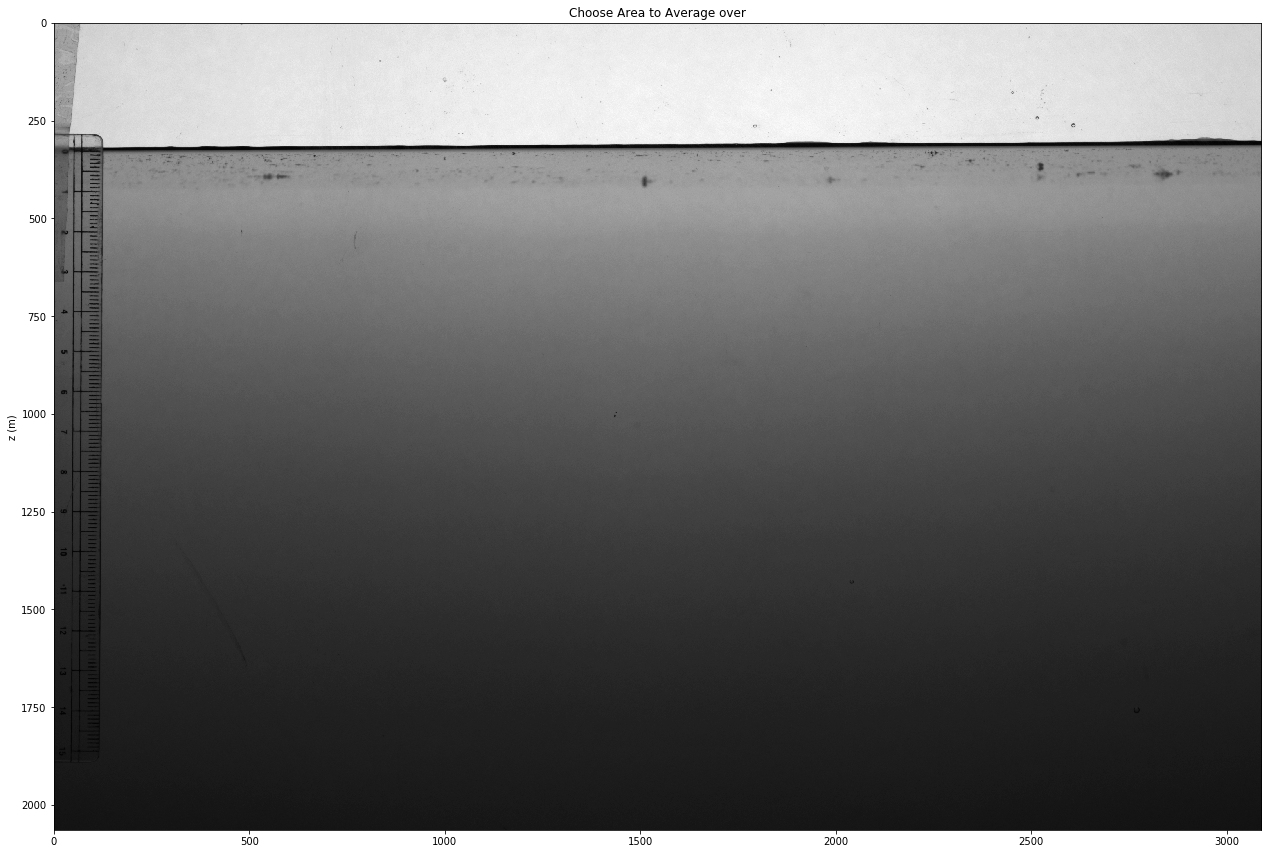

In [67]:
plt.figure()
plt.title('Choose Area to Average over')
plt.ylabel('z (m)')
plt.imshow(b_image, cmap='gist_gray')
print('Select the top left then the bottom right' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_0=int(np.round(density_locations[0][1]))
ztop_0=int(np.round(density_locations[1][1]))
xleft=int(np.round(density_locations[0][0]))
xright=int(np.round(density_locations[1][0]))

back_crop= b_image[zbot_0:ztop_0,xleft:xright]


In [69]:
#cropping and determining the background profile

log_back = np.log(back_crop)

#getting rid of unwated inf_values
log_back[np.isinf(log_back)]=np.nan

mean_ratio_profile = np.mean(log_back,1)
intensity = mean_ratio_profile[::-1]
depth_array = np.linspace(0,depth,len(mean_ratio_profile))

### Fixing up the background absorbtion profile

The top and bottom of the profile need to be fixed up

Choose bottom of top section
Location recorded


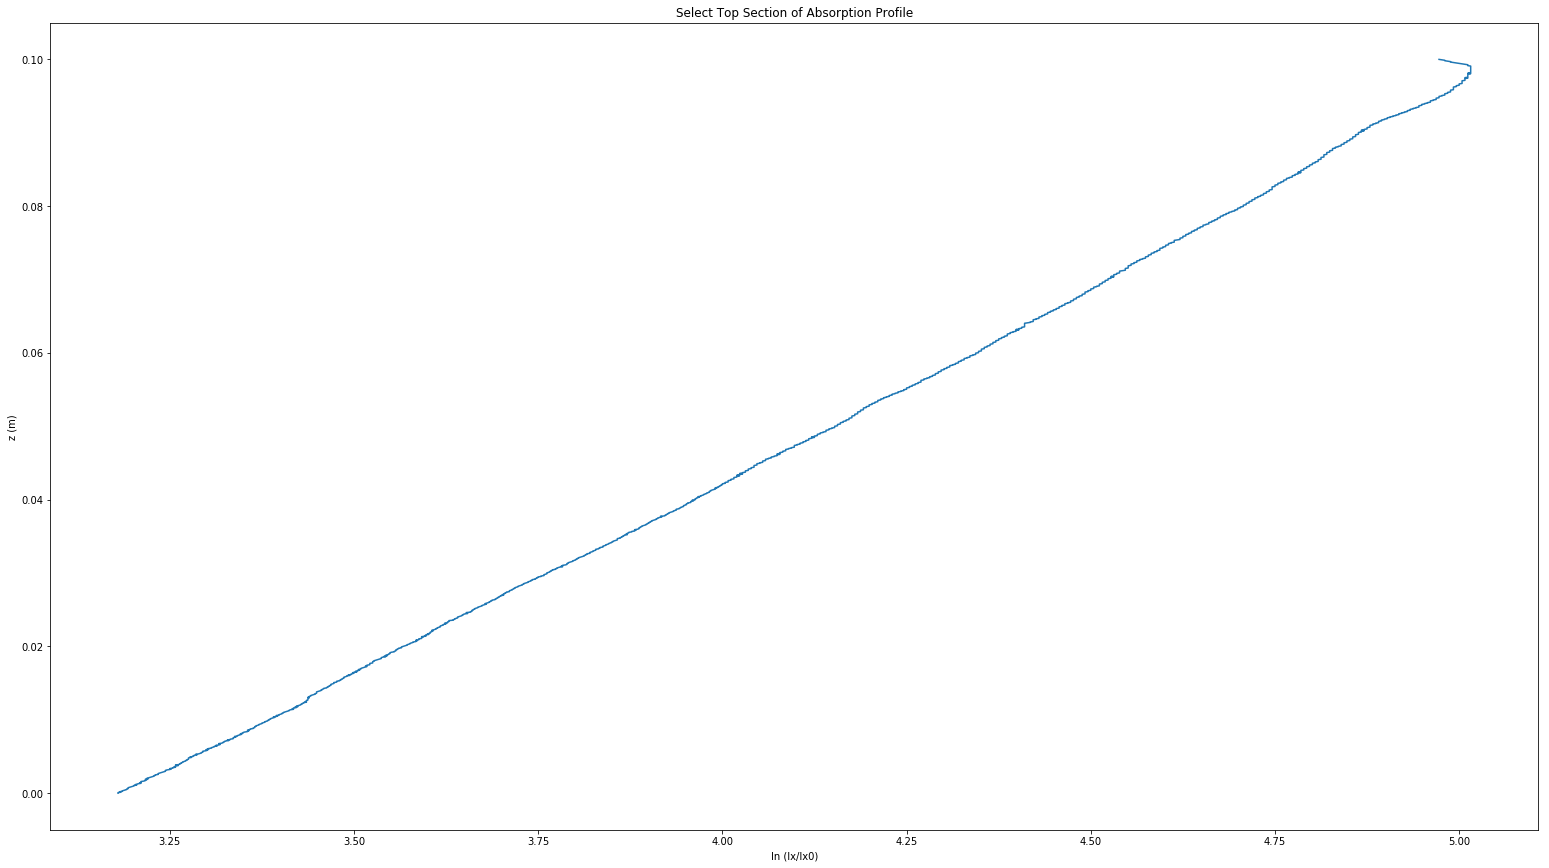

In [70]:
# fixing up the top of the profile, making it have a constant value
splintensity=np.copy(intensity)

plt.figure()
plt.plot(intensity,depth_array)
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.title('Select Top Section of Absorption Profile')
print('Choose bottom of top section')
topsection = plt.ginput(1)[0][1]
print('Location recorded')
ztop=index_find(depth_array,topsection) 
splintensity[ztop:]=splintensity[ztop]

Choose top then bottom
Locations recorded


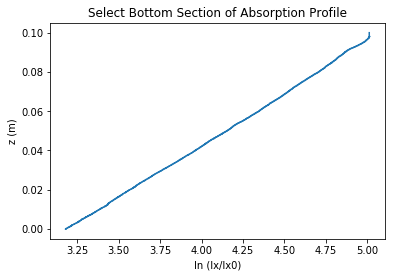

In [71]:
#fixing up the bottom of the profile, giving it a linear function
plt.figure()
plt.plot(splintensity,depth_array)
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.title('Select Bottom Section of Absorption Profile')
print('Choose top then bottom')
bottomsection = plt.ginput(2)
print('Locations recorded')

slope = (bottomsection[0][0]-bottomsection[1][0])/bottomsection[0][1]
intercept = bottomsection[0][1]-bottomsection[0][0]/slope
zbot=index_find(depth_array, bottomsection[0][1]) 
splintensity[0:zbot]=slope*(np.linspace(0,bottomsection[0][1], zbot)-intercept)

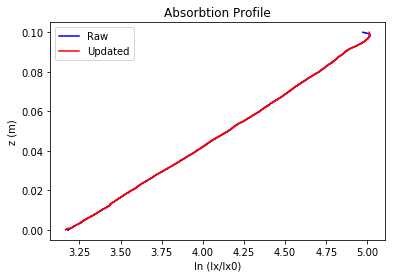

In [72]:
#plot that shows the raw vs the 'fixed' absorbtion profile

plt.figure()
plt.title('Absorbtion Profile')
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.plot(intensity,depth_array, 'b', label='Raw')
plt.plot(splintensity,depth_array, 'r',label='Updated')
plt.legend()

Position of density sample close to top, then close to bottom
Locations recorded


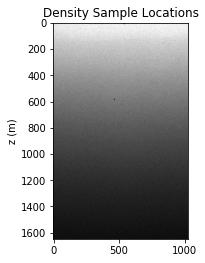

In [75]:
#determining the location of density samples (rho_bottom, rho_top) (this is usually the top and bottom)
plt.figure()
plt.title('Density Sample Locations')
plt.ylabel('z (m)')
plt.imshow(back_crop, cmap='gist_gray')
print('Position of density sample close to top, then close to bottom' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_rho=int(np.round(density_locations[0][1]))
ztop_rho=int(np.round(density_locations[1][1]))

beta = (rho_bottom-rho_top)/(splintensity[zbot_rho]-splintensity[ztop_rho])
splintensity_bottom_ref = splintensity[zbot_rho]

rho = rho_bottom+np.float64(beta*(splintensity-splintensity_bottom_ref))

Text(0.5, 1.0, 'Background Density')

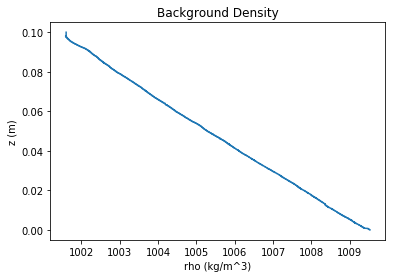

In [76]:
#plot of background density
plt.figure()
plt.plot(rho, depth_array)
plt.xlabel('rho (kg/m^3)')
plt.ylabel('z (m)')
plt.title('Background Density')

## Foreground Images
Choose the rapid foreground images you want in order to make a video of the moving ridge in density space


In [77]:
#now choose the pictures you want to look over, also creates a folder to save the video
foreground_path = askopenfilenames()
no_images = len(foreground_path)
os.mkdir('{}/densityfields'.format(os.path.dirname(foreground_path[0])))

In [78]:
%matplotlib inline
print('{} Images to analyse!'.format(no_images))
#inline backend used to stop hundreds of plots occuring, very important!!!!!!!

805 Images to analyse!


Below is code used to generation video of ridge

In [ ]:
ims=[]

fig = plt.figure(figsize=(15,8))
cmap = matplotlib.cm.coolwarm
cmap.set_under(color='black')




for i in range(no_images):

    f_image = cv2.imread(foreground_path[i],0)
    f_image_crop=f_image[zbot_0:ztop_0,:]
    log = np.log(f_image_crop)

    #getting rid of unwated inf_values
    log[np.isinf(log)]=np.nan
    
    density = rho_bottom+np.float64(beta*(log-splintensity_bottom_ref))
    delta_den=density[:,50:-50][::-1]-rho[:,None]
    density_filt=signal.medfilt2d(delta_den,3)
    a=density_filt
    a[a>3]=np.nan
    

    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    plt.title('Run {}'.format(run_num), fontsize=20)

    im=plt.imshow(a[50:,:][::-1], cmap=cmap, animated=True, vmin=-2,vmax=2, extent=[0,tank_length,depth,0])
    ims.append([im])


    if i in [100,200,300,400,500,600,700,800,900]:
        print('{} Images out of {} Done!'.format(i,no_images))
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)
plt.colorbar()
print('Saving!')
ani.save('{}/densityfields/run_{}.mp4'.format(os.path.dirname(foreground_path[0]),run_num))


C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
